In [1]:
!nvidia-smi

Sat May 15 07:22:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

In [4]:
!gdown --id 1ttE21JyaoCCbKpPM0Jg91V8WZap3BEQV --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
#!gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
#!gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
#!gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
#!gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
#!gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
#!gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
#!gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
#!gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
#!gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
#!gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1ttE21JyaoCCbKpPM0Jg91V8WZap3BEQV
To: /content/crypko_data.zip
452MB [00:12, 37.0MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [5]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

In [8]:
import os,shutil
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

In [9]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


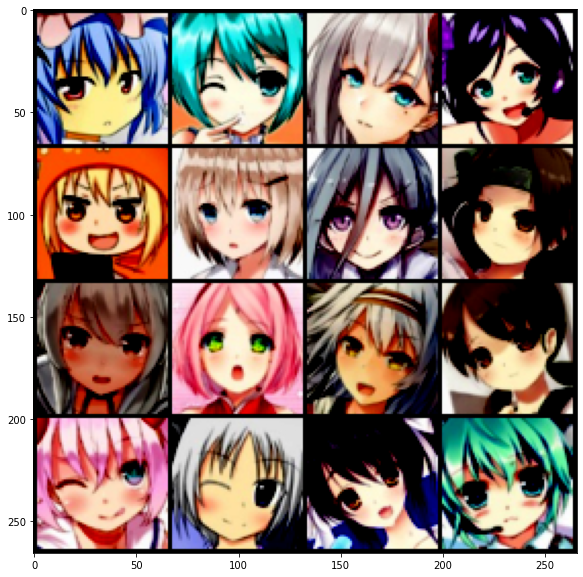

In [14]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


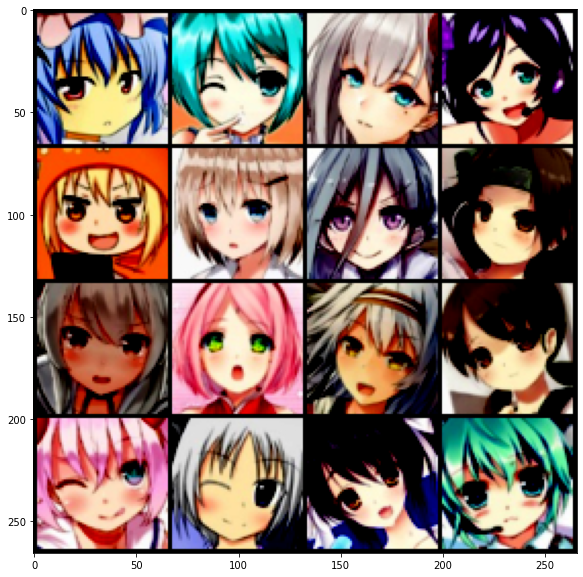

In [16]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]

plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

來源 : https://github.com/lucidrains/stylegan2-pytorch

In [20]:
! pip install stylegan2_pytorch

     |████████████████████████████████| 286kB 39.0MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 296kB 49.8MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 153kB 52.6MB/s 
     |████████████████████████████████| 174kB 52.3MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=89664a48e6a53778fada0fe5ddb5cb99f081db688124eb3cf8e80eec97efb193
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=97e1d0f9cb20937

In [ ]:
! stylegan2_pytorch --data /content/faces --name hw6GAN --results_dir /content/drive/MyDrive --models_dir /content/drive/MyDrive

continuing from previous epoch - 76
loading from version 1.8.1
hw7GAN</content/faces>:  51% 76000/150000 [00:00<?, ?it/s]G: 1.58 | D: 1.02 | GP: 0.03 | PL: 0.71
hw7GAN</content/faces>:  51% 76048/150000 [01:29<37:37:18,  1.83s/it]G: 1.86 | D: 0.80 | GP: 0.02 | PL: 0.71
hw7GAN</content/faces>:  51% 76099/150000 [03:02<37:21:00,  1.82s/it]G: 0.88 | D: 2.03 | GP: 3.91 | PL: 0.71
hw7GAN</content/faces>:  51% 76144/150000 [04:23<35:56:10,  1.75s/it]G: 0.62 | D: 1.29 | GP: 0.42 | PL: 0.71
hw7GAN</content/faces>:  51% 76195/150000 [05:56<37:07:04,  1.81s/it]G: 1.17 | D: 1.10 | GP: 0.10 | PL: 0.71
hw7GAN</content/faces>:  51% 76247/150000 [07:29<36:29:24,  1.78s/it]G: 0.69 | D: 1.18 | GP: 0.10 | PL: 0.71
hw7GAN</content/faces>:  51% 76297/150000 [09:01<38:11:38,  1.87s/it]G: 1.35 | D: 1.10 | GP: 0.58 | PL: 0.71
hw7GAN</content/faces>:  51% 76348/150000 [10:30<35:57:22,  1.76s/it]G: 0.56 | D: 0.73 | GP: 0.10 | PL: 0.71
hw7GAN</content/faces>:  51% 76400/150000 [12:04<35:47:53,  1.75s/it]G: 0.87

## StyleGAN Model code

In [21]:
import os
import fire
import random
from retry.api import retry_call
from tqdm import tqdm
from datetime import datetime
from functools import wraps
from stylegan2_pytorch import Trainer, NanException

import torch
import torch.multiprocessing as mp
import torch.distributed as dist

import numpy as np

def cast_list(el):
    return el if isinstance(el, list) else [el]

def timestamped_filename(prefix = 'generated-'):
    now = datetime.now()
    timestamp = now.strftime("%m-%d-%Y_%H-%M-%S")
    return f'{prefix}{timestamp}'

def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def run_training(rank, world_size, model_args, data, load_from, new, num_train_steps, name, seed):
    is_main = rank == 0
    is_ddp = world_size > 1

    if is_ddp:
        set_seed(seed)
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group('nccl', rank=rank, world_size=world_size)

        print(f"{rank + 1}/{world_size} process initialized.")

    model_args.update(
        is_ddp = is_ddp,
        rank = rank,
        world_size = world_size
    )

    model = Trainer(**model_args)

    if not new:
        model.load(load_from)
    else:
        model.clear()

    model.set_data_src(data)

    for _ in tqdm(range(num_train_steps - model.steps), initial = model.steps, total = num_train_steps, mininterval=10., desc=f'{name}<{data}>'):
        retry_call(model.train, tries=3, exceptions=NanException)
        if is_main and _ % 50 == 0:
            model.print_log()

    model.save(model.checkpoint_num)

    if is_ddp:
        dist.destroy_process_group()

def train_from_folder(
    data = './data',
    results_dir = './results',
    models_dir = './models',
    name = 'default',
    new = False,
    load_from = -1,
    image_size = 128,
    network_capacity = 16,
    fmap_max = 512,
    transparent = False,
    batch_size = 5,
    gradient_accumulate_every = 6,
    num_train_steps = 150000,
    learning_rate = 2e-4,
    lr_mlp = 0.1,
    ttur_mult = 1.5,
    rel_disc_loss = False,
    num_workers =  None,
    save_every = 1000,
    evaluate_every = 1000,
    generate = False,
    num_generate = 1,
    generate_interpolation = False,
    interpolation_num_steps = 100,
    save_frames = False,
    num_image_tiles = 8,
    trunc_psi = 0.75,
    mixed_prob = 0.9,
    fp16 = False,
    no_pl_reg = False,
    cl_reg = False,
    fq_layers = [],
    fq_dict_size = 256,
    attn_layers = [],
    no_const = False,
    aug_prob = 0.,
    aug_types = ['translation', 'cutout'],
    top_k_training = False,
    generator_top_k_gamma = 0.99,
    generator_top_k_frac = 0.5,
    dual_contrast_loss = False,
    dataset_aug_prob = 0.,
    multi_gpus = False,
    calculate_fid_every = None,
    calculate_fid_num_images = 12800,
    clear_fid_cache = False,
    seed = 42,
    log = False
):
    model_args = dict(
        name = name,
        results_dir = results_dir,
        models_dir = models_dir,
        batch_size = batch_size,
        gradient_accumulate_every = gradient_accumulate_every,
        image_size = image_size,
        network_capacity = network_capacity,
        fmap_max = fmap_max,
        transparent = transparent,
        lr = learning_rate,
        lr_mlp = lr_mlp,
        ttur_mult = ttur_mult,
        rel_disc_loss = rel_disc_loss,
        num_workers = num_workers,
        save_every = save_every,
        evaluate_every = evaluate_every,
        num_image_tiles = num_image_tiles,
        trunc_psi = trunc_psi,
        fp16 = fp16,
        no_pl_reg = no_pl_reg,
        cl_reg = cl_reg,
        fq_layers = fq_layers,
        fq_dict_size = fq_dict_size,
        attn_layers = attn_layers,
        no_const = no_const,
        aug_prob = aug_prob,
        aug_types = cast_list(aug_types),
        top_k_training = top_k_training,
        generator_top_k_gamma = generator_top_k_gamma,
        generator_top_k_frac = generator_top_k_frac,
        dual_contrast_loss = dual_contrast_loss,
        dataset_aug_prob = dataset_aug_prob,
        calculate_fid_every = calculate_fid_every,
        calculate_fid_num_images = calculate_fid_num_images,
        clear_fid_cache = clear_fid_cache,
        mixed_prob = mixed_prob,
        log = log
    )

    if generate:
        model = Trainer(**model_args)
        model.load(load_from)
        samples_name = timestamped_filename()
        for num in tqdm(range(num_generate)):
            model.evaluate(f'{num}', num_image_tiles)
        print(f'sample images generated at {results_dir}/{name}/{samples_name}')
        return

    if generate_interpolation:
        model = Trainer(**model_args)
        model.load(load_from)
        samples_name = timestamped_filename()
        model.generate_interpolation(samples_name, num_image_tiles, num_steps = interpolation_num_steps, save_frames = save_frames)
        print(f'interpolation generated at {results_dir}/{name}/{samples_name}')
        return

    world_size = torch.cuda.device_count()

    if world_size == 1 or not multi_gpus:
        run_training(0, 1, model_args, data, load_from, new, num_train_steps, name, seed)
        return

    mp.spawn(run_training,
        args=(world_size, model_args, data, load_from, new, num_train_steps, name, seed),
        nprocs=world_size,
        join=True)

def main():
    fire.Fire(train_from_folder)

In [22]:
import torch
import torch.nn.functional as F

def DiffAugment(x, types=[]):
    for p in types:
        for f in AUGMENT_FNS[p]:
            x = f(x)
    return x.contiguous()

def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x

def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x

def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x

def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x

def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [23]:
import os
import sys
import math
import json

from tqdm import tqdm
from math import floor, log2
from random import random
from shutil import rmtree
from functools import partial
import multiprocessing
from contextlib import contextmanager, ExitStack

import numpy as np

import torch
from torch import nn, einsum
from torch.utils import data
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

from einops import rearrange, repeat
from kornia.filters import filter2D

import torchvision
from torchvision import transforms
from stylegan2_pytorch.version import __version__
from stylegan2_pytorch.diff_augment import DiffAugment

from vector_quantize_pytorch import VectorQuantize

from PIL import Image
from pathlib import Path

try:
    from apex import amp
    APEX_AVAILABLE = True
except:
    APEX_AVAILABLE = False

import aim

assert torch.cuda.is_available(), 'You need to have an Nvidia GPU with CUDA installed.'


# constants

NUM_CORES = multiprocessing.cpu_count()
EXTS = ['jpg', 'jpeg', 'png']

# helper classes

class NanException(Exception):
    pass

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

class RandomApply(nn.Module):
    def __init__(self, prob, fn, fn_else = lambda x: x):
        super().__init__()
        self.fn = fn
        self.fn_else = fn_else
        self.prob = prob
    def forward(self, x):
        fn = self.fn if random() < self.prob else self.fn_else
        return fn(x)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = ChanNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

class ChanNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim = 1, unbiased = False, keepdim = True).sqrt()
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PermuteToFrom(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        out, *_, loss = self.fn(x)
        out = out.permute(0, 3, 1, 2)
        return out, loss

class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        f = torch.Tensor([1, 2, 1])
        self.register_buffer('f', f)
    def forward(self, x):
        f = self.f
        f = f[None, None, :] * f [None, :, None]
        return filter2D(x, f, normalized=True)

# attention

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding = 0, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, dim_head = 64, heads = 8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.nonlin = nn.GELU()
        self.to_q = nn.Conv2d(dim, inner_dim, 1, bias = False)
        self.to_kv = DepthWiseConv2d(dim, inner_dim * 2, 3, padding = 1, bias = False)
        self.to_out = nn.Conv2d(inner_dim, dim, 1)

    def forward(self, fmap):
        h, x, y = self.heads, *fmap.shape[-2:]
        q, k, v = (self.to_q(fmap), *self.to_kv(fmap).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = h), (q, k, v))

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)

        q = q * self.scale

        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        out = self.nonlin(out)
        return self.to_out(out)

# one layer of self-attention and feedforward, for images

attn_and_ff = lambda chan: nn.Sequential(*[
    Residual(PreNorm(chan, LinearAttention(chan))),
    Residual(PreNorm(chan, nn.Sequential(nn.Conv2d(chan, chan * 2, 1), leaky_relu(), nn.Conv2d(chan * 2, chan, 1))))
])

# helpers

def exists(val):
    return val is not None

@contextmanager
def null_context():
    yield

def combine_contexts(contexts):
    @contextmanager
    def multi_contexts():
        with ExitStack() as stack:
            yield [stack.enter_context(ctx()) for ctx in contexts]
    return multi_contexts

def default(value, d):
    return value if exists(value) else d

def cycle(iterable):
    while True:
        for i in iterable:
            yield i

def cast_list(el):
    return el if isinstance(el, list) else [el]

def is_empty(t):
    if isinstance(t, torch.Tensor):
        return t.nelement() == 0
    return not exists(t)

def raise_if_nan(t):
    if torch.isnan(t):
        raise NanException

def gradient_accumulate_contexts(gradient_accumulate_every, is_ddp, ddps):
    if is_ddp:
        num_no_syncs = gradient_accumulate_every - 1
        head = [combine_contexts(map(lambda ddp: ddp.no_sync, ddps))] * num_no_syncs
        tail = [null_context]
        contexts =  head + tail
    else:
        contexts = [null_context] * gradient_accumulate_every

    for context in contexts:
        with context():
            yield

def loss_backwards(fp16, loss, optimizer, loss_id, **kwargs):
    if fp16:
        with amp.scale_loss(loss, optimizer, loss_id) as scaled_loss:
            scaled_loss.backward(**kwargs)
    else:
        loss.backward(**kwargs)

def gradient_penalty(images, output, weight = 10):
    batch_size = images.shape[0]
    gradients = torch_grad(outputs=output, inputs=images,
                           grad_outputs=torch.ones(output.size(), device=images.device),
                           create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.reshape(batch_size, -1)
    return weight * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

def calc_pl_lengths(styles, images):
    device = images.device
    num_pixels = images.shape[2] * images.shape[3]
    pl_noise = torch.randn(images.shape, device=device) / math.sqrt(num_pixels)
    outputs = (images * pl_noise).sum()

    pl_grads = torch_grad(outputs=outputs, inputs=styles,
                          grad_outputs=torch.ones(outputs.shape, device=device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    return (pl_grads ** 2).sum(dim=2).mean(dim=1).sqrt()

def noise(n, latent_dim, device):
    return torch.randn(n, latent_dim).cuda(device)

def noise_list(n, layers, latent_dim, device):
    return [(noise(n, latent_dim, device), layers)]

def mixed_list(n, layers, latent_dim, device):
    tt = int(torch.rand(()).numpy() * layers)
    return noise_list(n, tt, latent_dim, device) + noise_list(n, layers - tt, latent_dim, device)

def latent_to_w(style_vectorizer, latent_descr):
    return [(style_vectorizer(z), num_layers) for z, num_layers in latent_descr]

def image_noise(n, im_size, device):
    return torch.FloatTensor(n, im_size, im_size, 1).uniform_(0., 1.).cuda(device)

def leaky_relu(p=0.2):
    return nn.LeakyReLU(p, inplace=True)

def evaluate_in_chunks(max_batch_size, model, *args):
    split_args = list(zip(*list(map(lambda x: x.split(max_batch_size, dim=0), args))))
    chunked_outputs = [model(*i) for i in split_args]
    if len(chunked_outputs) == 1:
        return chunked_outputs[0]
    return torch.cat(chunked_outputs, dim=0)

def styles_def_to_tensor(styles_def):
    return torch.cat([t[:, None, :].expand(-1, n, -1) for t, n in styles_def], dim=1)

def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

def slerp(val, low, high):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm * high_norm).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res

# losses

def gen_hinge_loss(fake, real):
    return fake.mean()

def hinge_loss(real, fake):
    return (F.relu(1 + real) + F.relu(1 - fake)).mean()

def dual_contrastive_loss(real_logits, fake_logits):
    device = real_logits.device
    real_logits, fake_logits = map(lambda t: rearrange(t, '... -> (...)'), (real_logits, fake_logits))

    def loss_half(t1, t2):
        t1 = rearrange(t1, 'i -> i ()')
        t2 = repeat(t2, 'j -> i j', i = t1.shape[0])
        t = torch.cat((t1, t2), dim = -1)
        return F.cross_entropy(t, torch.zeros(t1.shape[0], device = device, dtype = torch.long))

    return loss_half(real_logits, fake_logits) + loss_half(-fake_logits, -real_logits)

# dataset

def convert_rgb_to_transparent(image):
    if image.mode != 'RGBA':
        return image.convert('RGBA')
    return image

def convert_transparent_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

class expand_greyscale(object):
    def __init__(self, transparent):
        self.transparent = transparent

    def __call__(self, tensor):
        channels = tensor.shape[0]
        num_target_channels = 4 if self.transparent else 3

        if channels == num_target_channels:
            return tensor

        alpha = None
        if channels == 1:
            color = tensor.expand(3, -1, -1)
        elif channels == 2:
            color = tensor[:1].expand(3, -1, -1)
            alpha = tensor[1:]
        else:
            raise Exception(f'image with invalid number of channels given {channels}')

        if not exists(alpha) and self.transparent:
            alpha = torch.ones(1, *tensor.shape[1:], device=tensor.device)

        return color if not self.transparent else torch.cat((color, alpha))

def resize_to_minimum_size(min_size, image):
    if max(*image.size) < min_size:
        return torchvision.transforms.functional.resize(image, min_size)
    return image

class Dataset(data.Dataset):
    def __init__(self, folder, image_size, transparent = False, aug_prob = 0.):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for ext in EXTS for p in Path(f'{folder}').glob(f'**/*.{ext}')]
        assert len(self.paths) > 0, f'No images were found in {folder} for training'

        convert_image_fn = convert_transparent_to_rgb if not transparent else convert_rgb_to_transparent
        num_channels = 3 if not transparent else 4

        self.transform = transforms.Compose([
            transforms.Lambda(convert_image_fn),
            transforms.Lambda(partial(resize_to_minimum_size, image_size)),
            transforms.Resize(image_size),
            RandomApply(aug_prob, transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0), ratio=(0.98, 1.02)), transforms.CenterCrop(image_size)),
            transforms.ToTensor(),
            transforms.Lambda(expand_greyscale(transparent))
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

# augmentations

def random_hflip(tensor, prob):
    if prob > random():
        return tensor
    return torch.flip(tensor, dims=(3,))

class AugWrapper(nn.Module):
    def __init__(self, D, image_size):
        super().__init__()
        self.D = D

    def forward(self, images, prob = 0., types = [], detach = False):
        if random() < prob:
            images = random_hflip(images, prob=0.5)
            images = DiffAugment(images, types=types)

        if detach:
            images = images.detach()

        return self.D(images)

# stylegan2 classes

class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim, lr_mul = 1, bias = True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim))

        self.lr_mul = lr_mul

    def forward(self, input):
        return F.linear(input, self.weight * self.lr_mul, bias=self.bias * self.lr_mul)

class StyleVectorizer(nn.Module):
    def __init__(self, emb, depth, lr_mul = 0.1):
        super().__init__()

        layers = []
        for i in range(depth):
            layers.extend([EqualLinear(emb, emb, lr_mul), leaky_relu()])

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        return self.net(x)

class RGBBlock(nn.Module):
    def __init__(self, latent_dim, input_channel, upsample, rgba = False):
        super().__init__()
        self.input_channel = input_channel
        self.to_style = nn.Linear(latent_dim, input_channel)

        out_filters = 3 if not rgba else 4
        self.conv = Conv2DMod(input_channel, out_filters, 1, demod=False)

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            Blur()
        ) if upsample else None

    def forward(self, x, prev_rgb, istyle):
        b, c, h, w = x.shape
        style = self.to_style(istyle)
        x = self.conv(x, style)

        if exists(prev_rgb):
            x = x + prev_rgb

        if exists(self.upsample):
            x = self.upsample(x)

        return x

class Conv2DMod(nn.Module):
    def __init__(self, in_chan, out_chan, kernel, demod=True, stride=1, dilation=1, eps = 1e-8, **kwargs):
        super().__init__()
        self.filters = out_chan
        self.demod = demod
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.weight = nn.Parameter(torch.randn((out_chan, in_chan, kernel, kernel)))
        self.eps = eps
        nn.init.kaiming_normal_(self.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

    def _get_same_padding(self, size, kernel, dilation, stride):
        return ((size - 1) * (stride - 1) + dilation * (kernel - 1)) // 2

    def forward(self, x, y):
        b, c, h, w = x.shape

        w1 = y[:, None, :, None, None]
        w2 = self.weight[None, :, :, :, :]
        weights = w2 * (w1 + 1)

        if self.demod:
            d = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * d

        x = x.reshape(1, -1, h, w)

        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.filters, *ws)

        padding = self._get_same_padding(h, self.kernel, self.dilation, self.stride)
        x = F.conv2d(x, weights, padding=padding, groups=b)

        x = x.reshape(-1, self.filters, h, w)
        return x

class GeneratorBlock(nn.Module):
    def __init__(self, latent_dim, input_channels, filters, upsample = True, upsample_rgb = True, rgba = False):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None

        self.to_style1 = nn.Linear(latent_dim, input_channels)
        self.to_noise1 = nn.Linear(1, filters)
        self.conv1 = Conv2DMod(input_channels, filters, 3)
        
        self.to_style2 = nn.Linear(latent_dim, filters)
        self.to_noise2 = nn.Linear(1, filters)
        self.conv2 = Conv2DMod(filters, filters, 3)

        self.activation = leaky_relu()
        self.to_rgb = RGBBlock(latent_dim, filters, upsample_rgb, rgba)

    def forward(self, x, prev_rgb, istyle, inoise):
        if exists(self.upsample):
            x = self.upsample(x)

        inoise = inoise[:, :x.shape[2], :x.shape[3], :]
        noise1 = self.to_noise1(inoise).permute((0, 3, 2, 1))
        noise2 = self.to_noise2(inoise).permute((0, 3, 2, 1))

        style1 = self.to_style1(istyle)
        x = self.conv1(x, style1)
        x = self.activation(x + noise1)

        style2 = self.to_style2(istyle)
        x = self.conv2(x, style2)
        x = self.activation(x + noise2)

        rgb = self.to_rgb(x, prev_rgb, istyle)
        return x, rgb

class DiscriminatorBlock(nn.Module):
    def __init__(self, input_channels, filters, downsample=True):
        super().__init__()
        self.conv_res = nn.Conv2d(input_channels, filters, 1, stride = (2 if downsample else 1))

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, filters, 3, padding=1),
            leaky_relu(),
            nn.Conv2d(filters, filters, 3, padding=1),
            leaky_relu()
        )

        self.downsample = nn.Sequential(
            Blur(),
            nn.Conv2d(filters, filters, 3, padding = 1, stride = 2)
        ) if downsample else None

    def forward(self, x):
        res = self.conv_res(x)
        x = self.net(x)
        if exists(self.downsample):
            x = self.downsample(x)
        x = (x + res) * (1 / math.sqrt(2))
        return x

class Generator(nn.Module):
    def __init__(self, image_size, latent_dim, network_capacity = 16, transparent = False, attn_layers = [], no_const = False, fmap_max = 512):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.num_layers = int(log2(image_size) - 1)

        filters = [network_capacity * (2 ** (i + 1)) for i in range(self.num_layers)][::-1]

        set_fmap_max = partial(min, fmap_max)
        filters = list(map(set_fmap_max, filters))
        init_channels = filters[0]
        filters = [init_channels, *filters]

        in_out_pairs = zip(filters[:-1], filters[1:])
        self.no_const = no_const

        if no_const:
            self.to_initial_block = nn.ConvTranspose2d(latent_dim, init_channels, 4, 1, 0, bias=False)
        else:
            self.initial_block = nn.Parameter(torch.randn((1, init_channels, 4, 4)))

        self.initial_conv = nn.Conv2d(filters[0], filters[0], 3, padding=1)
        self.blocks = nn.ModuleList([])
        self.attns = nn.ModuleList([])

        for ind, (in_chan, out_chan) in enumerate(in_out_pairs):
            not_first = ind != 0
            not_last = ind != (self.num_layers - 1)
            num_layer = self.num_layers - ind

            attn_fn = attn_and_ff(in_chan) if num_layer in attn_layers else None

            self.attns.append(attn_fn)

            block = GeneratorBlock(
                latent_dim,
                in_chan,
                out_chan,
                upsample = not_first,
                upsample_rgb = not_last,
                rgba = transparent
            )
            self.blocks.append(block)

    def forward(self, styles, input_noise):
        batch_size = styles.shape[0]
        image_size = self.image_size

        if self.no_const:
            avg_style = styles.mean(dim=1)[:, :, None, None]
            x = self.to_initial_block(avg_style)
        else:
            x = self.initial_block.expand(batch_size, -1, -1, -1)

        rgb = None
        styles = styles.transpose(0, 1)
        x = self.initial_conv(x)

        for style, block, attn in zip(styles, self.blocks, self.attns):
            if exists(attn):
                x = attn(x)
            x, rgb = block(x, rgb, style, input_noise)

        return rgb

class Discriminator(nn.Module):
    def __init__(self, image_size, network_capacity = 16, fq_layers = [], fq_dict_size = 256, attn_layers = [], transparent = False, fmap_max = 512):
        super().__init__()
        num_layers = int(log2(image_size) - 1)
        num_init_filters = 3 if not transparent else 4

        blocks = []
        filters = [num_init_filters] + [(network_capacity * 4) * (2 ** i) for i in range(num_layers + 1)]

        set_fmap_max = partial(min, fmap_max)
        filters = list(map(set_fmap_max, filters))
        chan_in_out = list(zip(filters[:-1], filters[1:]))

        blocks = []
        attn_blocks = []
        quantize_blocks = []

        for ind, (in_chan, out_chan) in enumerate(chan_in_out):
            num_layer = ind + 1
            is_not_last = ind != (len(chan_in_out) - 1)

            block = DiscriminatorBlock(in_chan, out_chan, downsample = is_not_last)
            blocks.append(block)

            attn_fn = attn_and_ff(out_chan) if num_layer in attn_layers else None

            attn_blocks.append(attn_fn)

            quantize_fn = PermuteToFrom(VectorQuantize(out_chan, fq_dict_size)) if num_layer in fq_layers else None
            quantize_blocks.append(quantize_fn)

        self.blocks = nn.ModuleList(blocks)
        self.attn_blocks = nn.ModuleList(attn_blocks)
        self.quantize_blocks = nn.ModuleList(quantize_blocks)

        chan_last = filters[-1]
        latent_dim = 2 * 2 * chan_last

        self.final_conv = nn.Conv2d(chan_last, chan_last, 3, padding=1)
        self.flatten = Flatten()
        self.to_logit = nn.Linear(latent_dim, 1)

    def forward(self, x):
        b, *_ = x.shape

        quantize_loss = torch.zeros(1).to(x)

        for (block, attn_block, q_block) in zip(self.blocks, self.attn_blocks, self.quantize_blocks):
            x = block(x)

            if exists(attn_block):
                x = attn_block(x)

            if exists(q_block):
                x, loss = q_block(x)
                quantize_loss += loss

        x = self.final_conv(x)
        x = self.flatten(x)
        x = self.to_logit(x)
        return x.squeeze(), quantize_loss

class StyleGAN2(nn.Module):
    def __init__(self, image_size, latent_dim = 512, fmap_max = 512, style_depth = 8, network_capacity = 16, transparent = False, fp16 = False, cl_reg = False, steps = 1, lr = 1e-4, ttur_mult = 2, fq_layers = [], fq_dict_size = 256, attn_layers = [], no_const = False, lr_mlp = 0.1, rank = 0):
        super().__init__()
        self.lr = lr
        self.steps = steps
        self.ema_updater = EMA(0.995)

        self.S = StyleVectorizer(latent_dim, style_depth, lr_mul = lr_mlp)
        self.G = Generator(image_size, latent_dim, network_capacity, transparent = transparent, attn_layers = attn_layers, no_const = no_const, fmap_max = fmap_max)
        self.D = Discriminator(image_size, network_capacity, fq_layers = fq_layers, fq_dict_size = fq_dict_size, attn_layers = attn_layers, transparent = transparent, fmap_max = fmap_max)

        self.SE = StyleVectorizer(latent_dim, style_depth, lr_mul = lr_mlp)
        self.GE = Generator(image_size, latent_dim, network_capacity, transparent = transparent, attn_layers = attn_layers, no_const = no_const)

        self.D_cl = None

        if cl_reg:
            from contrastive_learner import ContrastiveLearner
            # experimental contrastive loss discriminator regularization
            assert not transparent, 'contrastive loss regularization does not work with transparent images yet'
            self.D_cl = ContrastiveLearner(self.D, image_size, hidden_layer='flatten')

        # wrapper for augmenting all images going into the discriminator
        self.D_aug = AugWrapper(self.D, image_size)

        # turn off grad for exponential moving averages
        set_requires_grad(self.SE, False)
        set_requires_grad(self.GE, False)

        # init optimizers
        generator_params = list(self.G.parameters()) + list(self.S.parameters())
        self.G_opt = Adam(generator_params, lr = self.lr, betas=(0.5, 0.9))
        self.D_opt = Adam(self.D.parameters(), lr = self.lr * ttur_mult, betas=(0.5, 0.9))

        # init weights
        self._init_weights()
        self.reset_parameter_averaging()

        self.cuda(rank)

        # startup apex mixed precision
        self.fp16 = fp16
        if fp16:
            (self.S, self.G, self.D, self.SE, self.GE), (self.G_opt, self.D_opt) = amp.initialize([self.S, self.G, self.D, self.SE, self.GE], [self.G_opt, self.D_opt], opt_level='O1', num_losses=3)

    def _init_weights(self):
        for m in self.modules():
            if type(m) in {nn.Conv2d, nn.Linear}:
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

        for block in self.G.blocks:
            nn.init.zeros_(block.to_noise1.weight)
            nn.init.zeros_(block.to_noise2.weight)
            nn.init.zeros_(block.to_noise1.bias)
            nn.init.zeros_(block.to_noise2.bias)

    def EMA(self):
        def update_moving_average(ma_model, current_model):
            for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
                old_weight, up_weight = ma_params.data, current_params.data
                ma_params.data = self.ema_updater.update_average(old_weight, up_weight)

        update_moving_average(self.SE, self.S)
        update_moving_average(self.GE, self.G)

    def reset_parameter_averaging(self):
        self.SE.load_state_dict(self.S.state_dict())
        self.GE.load_state_dict(self.G.state_dict())

    def forward(self, x):
        return x

class Trainer():
    def __init__(
        self,
        name = 'default',
        results_dir = 'results',
        models_dir = 'models',
        base_dir = './',
        image_size = 128,
        network_capacity = 16,
        fmap_max = 512,
        transparent = False,
        batch_size = 4,
        mixed_prob = 0.9,
        gradient_accumulate_every=1,
        lr = 2e-4,
        lr_mlp = 0.1,
        ttur_mult = 2,
        rel_disc_loss = False,
        num_workers = None,
        save_every = 1000,
        evaluate_every = 1000,
        num_image_tiles = 8,
        trunc_psi = 0.6,
        fp16 = False,
        cl_reg = False,
        no_pl_reg = False,
        fq_layers = [],
        fq_dict_size = 256,
        attn_layers = [],
        no_const = False,
        aug_prob = 0.,
        aug_types = ['translation', 'cutout'],
        top_k_training = False,
        generator_top_k_gamma = 0.99,
        generator_top_k_frac = 0.5,
        dual_contrast_loss = False,
        dataset_aug_prob = 0.,
        calculate_fid_every = None,
        calculate_fid_num_images = 12800,
        clear_fid_cache = False,
        is_ddp = False,
        rank = 0,
        world_size = 1,
        log = False,
        *args,
        **kwargs
    ):
        self.GAN_params = [args, kwargs]
        self.GAN = None

        self.name = name

        base_dir = Path(base_dir)
        self.base_dir = base_dir
        self.results_dir = base_dir / results_dir
        self.models_dir = base_dir / models_dir
        self.fid_dir = base_dir / 'fid' / name
        self.config_path = self.models_dir / name / '.config.json'

        assert log2(image_size).is_integer(), 'image size must be a power of 2 (64, 128, 256, 512, 1024)'
        self.image_size = image_size
        self.network_capacity = network_capacity
        self.fmap_max = fmap_max
        self.transparent = transparent

        self.fq_layers = cast_list(fq_layers)
        self.fq_dict_size = fq_dict_size
        self.has_fq = len(self.fq_layers) > 0

        self.attn_layers = cast_list(attn_layers)
        self.no_const = no_const

        self.aug_prob = aug_prob
        self.aug_types = aug_types

        self.lr = lr
        self.lr_mlp = lr_mlp
        self.ttur_mult = ttur_mult
        self.rel_disc_loss = rel_disc_loss
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mixed_prob = mixed_prob

        self.num_image_tiles = num_image_tiles
        self.evaluate_every = evaluate_every
        self.save_every = save_every
        self.steps = 0

        self.av = None
        self.trunc_psi = trunc_psi

        self.no_pl_reg = no_pl_reg
        self.pl_mean = None

        self.gradient_accumulate_every = gradient_accumulate_every

        assert not fp16 or fp16 and APEX_AVAILABLE, 'Apex is not available for you to use mixed precision training'
        self.fp16 = fp16

        self.cl_reg = cl_reg

        self.d_loss = 0
        self.g_loss = 0
        self.q_loss = None
        self.last_gp_loss = None
        self.last_cr_loss = None
        self.last_fid = None

        self.pl_length_ma = EMA(0.99)
        self.init_folders()

        self.loader = None
        self.dataset_aug_prob = dataset_aug_prob

        self.calculate_fid_every = calculate_fid_every
        self.calculate_fid_num_images = calculate_fid_num_images
        self.clear_fid_cache = clear_fid_cache

        self.top_k_training = top_k_training
        self.generator_top_k_gamma = generator_top_k_gamma
        self.generator_top_k_frac = generator_top_k_frac

        self.dual_contrast_loss = dual_contrast_loss

        assert not (is_ddp and cl_reg), 'Contrastive loss regularization does not work well with multi GPUs yet'
        self.is_ddp = is_ddp
        self.is_main = rank == 0
        self.rank = rank
        self.world_size = world_size

        self.logger = aim.Session(experiment=name) if log else None

    @property
    def image_extension(self):
        return 'jpg' if not self.transparent else 'png'

    @property
    def checkpoint_num(self):
        return floor(self.steps // self.save_every)

    @property
    def hparams(self):
        return {'image_size': self.image_size, 'network_capacity': self.network_capacity}
        
    def init_GAN(self):
        args, kwargs = self.GAN_params
        self.GAN = StyleGAN2(lr = self.lr, lr_mlp = self.lr_mlp, ttur_mult = self.ttur_mult, image_size = self.image_size, network_capacity = self.network_capacity, fmap_max = self.fmap_max, transparent = self.transparent, fq_layers = self.fq_layers, fq_dict_size = self.fq_dict_size, attn_layers = self.attn_layers, fp16 = self.fp16, cl_reg = self.cl_reg, no_const = self.no_const, rank = self.rank, *args, **kwargs)

        if self.is_ddp:
            ddp_kwargs = {'device_ids': [self.rank]}
            self.S_ddp = DDP(self.GAN.S, **ddp_kwargs)
            self.G_ddp = DDP(self.GAN.G, **ddp_kwargs)
            self.D_ddp = DDP(self.GAN.D, **ddp_kwargs)
            self.D_aug_ddp = DDP(self.GAN.D_aug, **ddp_kwargs)

        if exists(self.logger):
            self.logger.set_params(self.hparams)

    def write_config(self):
        self.config_path.write_text(json.dumps(self.config()))

    def load_config(self):
        config = self.config() if not self.config_path.exists() else json.loads(self.config_path.read_text())
        self.image_size = config['image_size']
        self.network_capacity = config['network_capacity']
        self.transparent = config['transparent']
        self.fq_layers = config['fq_layers']
        self.fq_dict_size = config['fq_dict_size']
        self.fmap_max = config.pop('fmap_max', 512)
        self.attn_layers = config.pop('attn_layers', [])
        self.no_const = config.pop('no_const', False)
        self.lr_mlp = config.pop('lr_mlp', 0.1)
        del self.GAN
        self.init_GAN()

    def config(self):
        return {'image_size': self.image_size, 'network_capacity': self.network_capacity, 'lr_mlp': self.lr_mlp, 'transparent': self.transparent, 'fq_layers': self.fq_layers, 'fq_dict_size': self.fq_dict_size, 'attn_layers': self.attn_layers, 'no_const': self.no_const}

    def set_data_src(self, folder):
        self.dataset = Dataset(folder, self.image_size, transparent = self.transparent, aug_prob = self.dataset_aug_prob)
        num_workers = num_workers = default(self.num_workers, NUM_CORES if not self.is_ddp else 0)
        sampler = DistributedSampler(self.dataset, rank=self.rank, num_replicas=self.world_size, shuffle=True) if self.is_ddp else None
        dataloader = data.DataLoader(self.dataset, num_workers = num_workers, batch_size = math.ceil(self.batch_size / self.world_size), sampler = sampler, shuffle = not self.is_ddp, drop_last = True, pin_memory = True)
        self.loader = cycle(dataloader)

        # auto set augmentation prob for user if dataset is detected to be low
        num_samples = len(self.dataset)
        if not exists(self.aug_prob) and num_samples < 1e5:
            self.aug_prob = min(0.5, (1e5 - num_samples) * 3e-6)
            print(f'autosetting augmentation probability to {round(self.aug_prob * 100)}%')

    def train(self):
        assert exists(self.loader), 'You must first initialize the data source with `.set_data_src(<folder of images>)`'

        if not exists(self.GAN):
            self.init_GAN()

        self.GAN.train()
        total_disc_loss = torch.tensor(0.).cuda(self.rank)
        total_gen_loss = torch.tensor(0.).cuda(self.rank)

        batch_size = math.ceil(self.batch_size / self.world_size)

        image_size = self.GAN.G.image_size
        latent_dim = self.GAN.G.latent_dim
        num_layers = self.GAN.G.num_layers

        aug_prob   = self.aug_prob
        aug_types  = self.aug_types
        aug_kwargs = {'prob': aug_prob, 'types': aug_types}

        apply_gradient_penalty = self.steps % 4 == 0
        apply_path_penalty = not self.no_pl_reg and self.steps > 5000 and self.steps % 32 == 0
        apply_cl_reg_to_generated = self.steps > 20000

        S = self.GAN.S if not self.is_ddp else self.S_ddp
        G = self.GAN.G if not self.is_ddp else self.G_ddp
        D = self.GAN.D if not self.is_ddp else self.D_ddp
        D_aug = self.GAN.D_aug if not self.is_ddp else self.D_aug_ddp

        backwards = partial(loss_backwards, self.fp16)

        if exists(self.GAN.D_cl):
            self.GAN.D_opt.zero_grad()

            if apply_cl_reg_to_generated:
                for i in range(self.gradient_accumulate_every):
                    get_latents_fn = mixed_list if random() < self.mixed_prob else noise_list
                    style = get_latents_fn(batch_size, num_layers, latent_dim, device=self.rank)
                    noise = image_noise(batch_size, image_size, device=self.rank)

                    w_space = latent_to_w(self.GAN.S, style)
                    w_styles = styles_def_to_tensor(w_space)

                    generated_images = self.GAN.G(w_styles, noise)
                    self.GAN.D_cl(generated_images.clone().detach(), accumulate=True)

            for i in range(self.gradient_accumulate_every):
                image_batch = next(self.loader).cuda(self.rank)
                self.GAN.D_cl(image_batch, accumulate=True)

            loss = self.GAN.D_cl.calculate_loss()
            self.last_cr_loss = loss.clone().detach().item()
            backwards(loss, self.GAN.D_opt, loss_id = 0)

            self.GAN.D_opt.step()

        # setup losses

        if not self.dual_contrast_loss:
            D_loss_fn = hinge_loss
            G_loss_fn = gen_hinge_loss
            G_requires_reals = False
        else:
            D_loss_fn = dual_contrastive_loss
            G_loss_fn = dual_contrastive_loss
            G_requires_reals = True

        # train discriminator

        avg_pl_length = self.pl_mean
        self.GAN.D_opt.zero_grad()

        for i in gradient_accumulate_contexts(self.gradient_accumulate_every, self.is_ddp, ddps=[D_aug, S, G]):
            get_latents_fn = mixed_list if random() < self.mixed_prob else noise_list
            style = get_latents_fn(batch_size, num_layers, latent_dim, device=self.rank)
            noise = image_noise(batch_size, image_size, device=self.rank)

            w_space = latent_to_w(S, style)
            w_styles = styles_def_to_tensor(w_space)

            generated_images = G(w_styles, noise)
            fake_output, fake_q_loss = D_aug(generated_images.clone().detach(), detach = True, **aug_kwargs)

            image_batch = next(self.loader).cuda(self.rank)
            image_batch.requires_grad_()
            real_output, real_q_loss = D_aug(image_batch, **aug_kwargs)

            real_output_loss = real_output
            fake_output_loss = fake_output

            if self.rel_disc_loss:
                real_output_loss = real_output_loss - fake_output.mean()
                fake_output_loss = fake_output_loss - real_output.mean()

            divergence = D_loss_fn(real_output_loss, fake_output_loss)
            disc_loss = divergence

            if self.has_fq:
                quantize_loss = (fake_q_loss + real_q_loss).mean()
                self.q_loss = float(quantize_loss.detach().item())

                disc_loss = disc_loss + quantize_loss

            if apply_gradient_penalty:
                gp = gradient_penalty(image_batch, real_output)
                self.last_gp_loss = gp.clone().detach().item()
                self.track(self.last_gp_loss, 'GP')
                disc_loss = disc_loss + gp

            disc_loss = disc_loss / self.gradient_accumulate_every
            disc_loss.register_hook(raise_if_nan)
            backwards(disc_loss, self.GAN.D_opt, loss_id = 1)

            total_disc_loss += divergence.detach().item() / self.gradient_accumulate_every

        self.d_loss = float(total_disc_loss)
        self.track(self.d_loss, 'D')

        self.GAN.D_opt.step()

        # train generator

        self.GAN.G_opt.zero_grad()

        for i in gradient_accumulate_contexts(self.gradient_accumulate_every, self.is_ddp, ddps=[S, G, D_aug]):
            style = get_latents_fn(batch_size, num_layers, latent_dim, device=self.rank)
            noise = image_noise(batch_size, image_size, device=self.rank)

            w_space = latent_to_w(S, style)
            w_styles = styles_def_to_tensor(w_space)

            generated_images = G(w_styles, noise)
            fake_output, _ = D_aug(generated_images, **aug_kwargs)
            fake_output_loss = fake_output

            real_output = None
            if G_requires_reals:
                image_batch = next(self.loader).cuda(self.rank)
                real_output, _ = D_aug(image_batch, detach = True, **aug_kwargs)
                real_output = real_output.detach()

            if self.top_k_training:
                epochs = (self.steps * batch_size * self.gradient_accumulate_every) / len(self.dataset)
                k_frac = max(self.generator_top_k_gamma ** epochs, self.generator_top_k_frac)
                k = math.ceil(batch_size * k_frac)

                if k != batch_size:
                    fake_output_loss, _ = fake_output_loss.topk(k=k, largest=False)

            loss = G_loss_fn(fake_output_loss, real_output)
            gen_loss = loss

            if apply_path_penalty:
                pl_lengths = calc_pl_lengths(w_styles, generated_images)
                avg_pl_length = np.mean(pl_lengths.detach().cpu().numpy())

                if not is_empty(self.pl_mean):
                    pl_loss = ((pl_lengths - self.pl_mean) ** 2).mean()
                    if not torch.isnan(pl_loss):
                        gen_loss = gen_loss + pl_loss

            gen_loss = gen_loss / self.gradient_accumulate_every
            gen_loss.register_hook(raise_if_nan)
            backwards(gen_loss, self.GAN.G_opt, loss_id = 2)

            total_gen_loss += loss.detach().item() / self.gradient_accumulate_every

        self.g_loss = float(total_gen_loss)
        self.track(self.g_loss, 'G')

        self.GAN.G_opt.step()

        # calculate moving averages

        if apply_path_penalty and not np.isnan(avg_pl_length):
            self.pl_mean = self.pl_length_ma.update_average(self.pl_mean, avg_pl_length)
            self.track(self.pl_mean, 'PL')

        if self.is_main and self.steps % 10 == 0 and self.steps > 20000:
            self.GAN.EMA()

        if self.is_main and self.steps <= 25000 and self.steps % 1000 == 2:
            self.GAN.reset_parameter_averaging()

        # save from NaN errors

        if any(torch.isnan(l) for l in (total_gen_loss, total_disc_loss)):
            print(f'NaN detected for generator or discriminator. Loading from checkpoint #{self.checkpoint_num}')
            self.load(self.checkpoint_num)
            raise NanException

        # periodically save results

        if self.is_main:
            if self.steps % self.save_every == 0:
                self.save(self.checkpoint_num)

            if self.steps % self.evaluate_every == 0 or (self.steps % 100 == 0 and self.steps < 2500):
                self.evaluate(floor(self.steps / self.evaluate_every))

            if exists(self.calculate_fid_every) and self.steps % self.calculate_fid_every == 0 and self.steps != 0:
                num_batches = math.ceil(self.calculate_fid_num_images / self.batch_size)
                fid = self.calculate_fid(num_batches)
                self.last_fid = fid

                with open(str(self.results_dir / self.name / f'fid_scores.txt'), 'a') as f:
                    f.write(f'{self.steps},{fid}\n')

        self.steps += 1
        self.av = None

    @torch.no_grad()
    def evaluate(self, num = 0, trunc = 1.0):
        self.GAN.eval()
        ext = self.image_extension
        num_rows = self.num_image_tiles
    
        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        # latents and noise

        latents = noise_list(num_rows ** 2, num_layers, latent_dim, device=self.rank)
        n = image_noise(num_rows ** 2, image_size, device=self.rank)

        # regular

        generated_images = self.generate_truncated(self.GAN.S, self.GAN.G, latents, n, trunc_psi = self.trunc_psi)
        torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}.{ext}'), nrow=num_rows)
        
        # moving averages

        # generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, n, trunc_psi = self.trunc_psi)
        # torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}-ema.{ext}'), nrow=num_rows)

        # mixing regularities

        # def tile(a, dim, n_tile):
        #     init_dim = a.size(dim)
        #     repeat_idx = [1] * a.dim()
        #     repeat_idx[dim] = n_tile
        #     a = a.repeat(*(repeat_idx))
        #     order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda(self.rank)
        #     return torch.index_select(a, dim, order_index)

        # nn = noise(num_rows, latent_dim, device=self.rank)
        # tmp1 = tile(nn, 0, num_rows)
        # tmp2 = nn.repeat(num_rows, 1)

        # tt = int(num_layers / 2)
        # mixed_latents = [(tmp1, tt), (tmp2, num_layers - tt)]

        # #generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, mixed_latents, n, trunc_psi = self.trunc_psi)
        # #torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}-mr.{ext}'), nrow=num_rows)

    @torch.no_grad()
    def calculate_fid(self, num_batches):
        from pytorch_fid import fid_score
        torch.cuda.empty_cache()

        real_path = self.fid_dir / 'real'
        fake_path = self.fid_dir / 'fake'

        # remove any existing files used for fid calculation and recreate directories

        if not real_path.exists() or self.clear_fid_cache:
            rmtree(real_path, ignore_errors=True)
            os.makedirs(real_path)

            for batch_num in tqdm(range(num_batches), desc='calculating FID - saving reals'):
                real_batch = next(self.loader)
                for k, image in enumerate(real_batch.unbind(0)):
                    filename = str(k + batch_num * self.batch_size)
                    torchvision.utils.save_image(image, str(real_path / f'{filename}.png'))

        # generate a bunch of fake images in results / name / fid_fake

        rmtree(fake_path, ignore_errors=True)
        os.makedirs(fake_path)

        self.GAN.eval()
        ext = self.image_extension

        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        for batch_num in tqdm(range(num_batches), desc='calculating FID - saving generated'):
            # latents and noise
            latents = noise_list(self.batch_size, num_layers, latent_dim, device=self.rank)
            noise = image_noise(self.batch_size, image_size, device=self.rank)

            # moving averages
            generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, noise, trunc_psi = self.trunc_psi)

            for j, image in enumerate(generated_images.unbind(0)):
                torchvision.utils.save_image(image, str(fake_path / f'{str(j + batch_num * self.batch_size)}-ema.{ext}'))

        return fid_score.calculate_fid_given_paths([str(real_path), str(fake_path)], 256, noise.device, 2048)

    @torch.no_grad()
    def truncate_style(self, tensor, trunc_psi = 0.75):
        S = self.GAN.S
        batch_size = self.batch_size
        latent_dim = self.GAN.G.latent_dim

        if not exists(self.av):
            z = noise(2000, latent_dim, device=self.rank)
            samples = evaluate_in_chunks(batch_size, S, z).cpu().numpy()
            self.av = np.mean(samples, axis = 0)
            self.av = np.expand_dims(self.av, axis = 0)

        av_torch = torch.from_numpy(self.av).cuda(self.rank)
        tensor = trunc_psi * (tensor - av_torch) + av_torch
        return tensor

    @torch.no_grad()
    def truncate_style_defs(self, w, trunc_psi = 0.75):
        w_space = []
        for tensor, num_layers in w:
            tensor = self.truncate_style(tensor, trunc_psi = trunc_psi)            
            w_space.append((tensor, num_layers))
        return w_space

    @torch.no_grad()
    def generate_truncated(self, S, G, style, noi, trunc_psi = 0.75, num_image_tiles = 8):
        w = map(lambda t: (S(t[0]), t[1]), style)
        w_truncated = self.truncate_style_defs(w, trunc_psi = trunc_psi)
        w_styles = styles_def_to_tensor(w_truncated)
        generated_images = evaluate_in_chunks(self.batch_size, G, w_styles, noi)
        return generated_images.clamp_(0., 1.)

    @torch.no_grad()
    def generate_interpolation(self, num = 0, num_image_tiles = 8, trunc = 1.0, num_steps = 100, save_frames = False):
        self.GAN.eval()
        ext = self.image_extension
        num_rows = num_image_tiles

        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        # latents and noise

        latents_low = noise(num_rows ** 2, latent_dim, device=self.rank)
        latents_high = noise(num_rows ** 2, latent_dim, device=self.rank)
        n = image_noise(num_rows ** 2, image_size, device=self.rank)

        ratios = torch.linspace(0., 8., num_steps)

        frames = []
        for ratio in tqdm(ratios):
            interp_latents = slerp(ratio, latents_low, latents_high)
            latents = [(interp_latents, num_layers)]
            generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, n, trunc_psi = self.trunc_psi)
            images_grid = torchvision.utils.make_grid(generated_images, nrow = num_rows)
            pil_image = transforms.ToPILImage()(images_grid.cpu())
            
            if self.transparent:
                background = Image.new("RGBA", pil_image.size, (255, 255, 255))
                pil_image = Image.alpha_composite(background, pil_image)
                
            frames.append(pil_image)

        frames[0].save(str(self.results_dir / self.name / f'{str(num)}.gif'), save_all=True, append_images=frames[1:], duration=80, loop=0, optimize=True)

        if save_frames:
            folder_path = (self.results_dir / self.name / f'{str(num)}')
            folder_path.mkdir(parents=True, exist_ok=True)
            for ind, frame in enumerate(frames):
                frame.save(str(folder_path / f'{str(ind)}.{ext}'))

    def print_log(self):
        data = [
            ('G', self.g_loss),
            ('D', self.d_loss),
            ('GP', self.last_gp_loss),
            ('PL', self.pl_mean),
            ('CR', self.last_cr_loss),
            ('Q', self.q_loss),
            ('FID', self.last_fid)
        ]

        data = [d for d in data if exists(d[1])]
        log = ' | '.join(map(lambda n: f'{n[0]}: {n[1]:.2f}', data))
        print(log)

    def track(self, value, name):
        if not exists(self.logger):
            return
        self.logger.track(value, name = name)

    def model_name(self, num):
        return str(self.models_dir / self.name / f'model_{num}.pt')

    def init_folders(self):
        (self.results_dir / self.name).mkdir(parents=True, exist_ok=True)
        (self.models_dir / self.name).mkdir(parents=True, exist_ok=True)

    def clear(self):
        rmtree(str(self.models_dir / self.name), True)
        rmtree(str(self.results_dir / self.name), True)
        rmtree(str(self.fid_dir), True)
        rmtree(str(self.config_path), True)
        self.init_folders()

    def save(self, num):
        save_data = {
            'GAN': self.GAN.state_dict(),
            'version': __version__
        }

        if self.GAN.fp16:
            save_data['amp'] = amp.state_dict()

        torch.save(save_data, self.model_name(num))
        self.write_config()

    def load(self, num = -1):
        self.load_config()

        name = num
        if num == -1:
            file_paths = [p for p in Path(self.models_dir / self.name).glob('model_*.pt')]
            saved_nums = sorted(map(lambda x: int(x.stem.split('_')[1]), file_paths))
            if len(saved_nums) == 0:
                return
            name = saved_nums[-1]
            print(f'continuing from previous epoch - {name}')

        self.steps = name * self.save_every

        load_data = torch.load(self.model_name(name))

        if 'version' in load_data:
            print(f"loading from version {load_data['version']}")

        try:
            self.GAN.load_state_dict(load_data['GAN'])
        except Exception as e:
            print('unable to load save model. please try downgrading the package to the version specified by the saved model')
            raise e
        if self.GAN.fp16 and 'amp' in load_data:
            amp.load_state_dict(load_data['amp'])

class ModelLoader:
    def __init__(self, *, base_dir, name = 'default', load_from = -1):
        self.model = Trainer(name = name, base_dir = base_dir)
        self.model.load(load_from)

    def noise_to_styles(self, noise, trunc_psi = None):
        noise = noise.cuda()
        w = self.model.GAN.SE(noise)
        if exists(trunc_psi):
            w = self.model.truncate_style(w)
        return w

    def styles_to_images(self, w):
        batch_size, *_ = w.shape
        num_layers = self.model.GAN.GE.num_layers
        image_size = self.model.image_size
        w_def = [(w, num_layers)]

        w_tensors = styles_def_to_tensor(w_def)
        noise = image_noise(batch_size, image_size, device = 0)

        images = self.model.GAN.GE(w_tensors, noise)
        images.clamp_(0., 1.)
        return images

# Inference


In [24]:
# Generate 1000 images
train_from_folder(data='/content/faces',name='hw6GAN',
                  models_dir='/content/drive/MyDrive',
                  num_train_steps=0,
                  num_generate=1000,
                  num_image_tiles=1,
                  generate=True)

continuing from previous epoch - 100


  0%|          | 0/1000 [00:00<?, ?it/s]

loading from version 1.8.1


100%|██████████| 1000/1000 [00:11<00:00, 90.21it/s]

sample images generated at ./results/hw7GAN/generated-05-15-2021_07-36-44


In [25]:
# Resize image to (64,64)
trans = transforms.Resize((64, 64))
path = '/content/results/hw6GAN'
out_path = './output/'
os.makedirs('output', exist_ok=True)
for root in os.listdir(path):
  im = Image.open(path + '/' + root)
  im = trans(im)
  save_name = out_path + root
  im.save(save_name)
print(f'Resize {len(os.listdir(path))} imgs')

Resize 1000 imgs


In [26]:
#Sample images to show
tran_im = transforms.ToTensor()
r = torch.randint(0,1000,(16,))
imgs_sample = []
for i in r:
  s = out_path + str(i.item()) + '.jpg'
  pic = tran_im(Image.open(s))
  imgs_sample.append(pic)

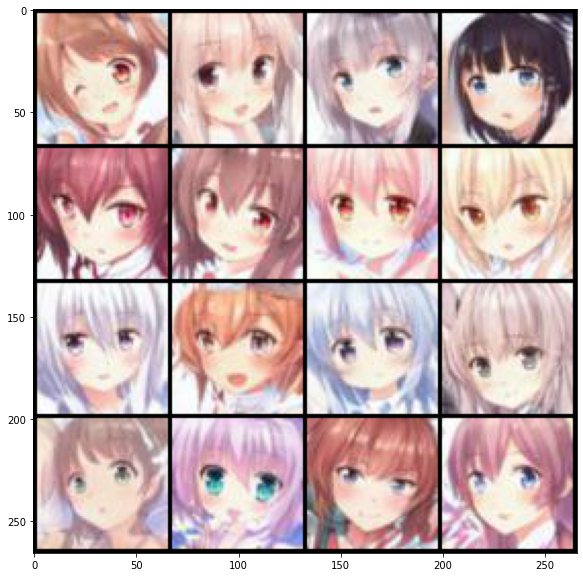

In [27]:
grid_img = torchvision.utils.make_grid(imgs_sample, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [28]:
# # Save the generated images.
# os.makedirs('output', exist_ok=True)
# for i in range(1000):
#     torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# # Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/output
/content
